# Import modules

In [19]:
import pandas as pd
import numpy as np
import os
from PIL import Image
from PIL import ImageOps
from tqdm import tqdm
import torch
import torch.nn as nn  # NN networks (CNN, RNN, losses)
import torch.optim as optim  # Aptimizers (Adam, Adadelta, Adagrad)
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset  # Dataset manager
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

from from_imgs_to_csv import generate_csv

# Generate Dataset

In [21]:
create_dataset = False
if create_dataset:
    generate_csv(win_size=3, dump_to_file=1000)

# Define constants

In [5]:
datasets_path = r"..\datasets\csv_files"
img_path = r"..\datasets\images"
models_path = r"..\models"

# Create DataLoader

In [6]:
class NoisedImgs(Dataset):
    def __init__(self, dataset_path):
        super().__init__()

        self.data = pd.read_csv(dataset_path, header=None)

        target_ind = self.data.shape[1] - 1
        self.data.rename(columns={target_ind: "target"}, inplace=True)

        self.targets = self.data["target"]
        self.data.drop(columns="target", inplace=True)

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, index):
        x = torch.Tensor(self.data.iloc[index].to_numpy()).float()
        y = torch.Tensor([self.targets.iloc[index]]).float()
        return x, y


## Load dataset

In [7]:
win_size = 3
dataset = NoisedImgs(f"{datasets_path}\data_win{win_size}.csv")
batch_size = 256

In [8]:
train_size = int(dataset.__len__() * 0.8)
test_size = dataset.__len__() - train_size
print(f"{train_size = }\n{test_size = },\n{train_size + test_size = }")

train_size = 2956800
test_size = 739200,
train_size + test_size = 3696000


In [9]:
train_set, test_set = torch.utils.data.random_split(dataset, [train_size, test_size])
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=True)

# NN Model

In [10]:
class DefaultModel(nn.Module):
    def __init__(self, in_len, out_len) -> None:
        super().__init__()
        self.in_len = in_len
        self.out_len = out_len
        self.hid_n = 20
        
        self.fcs = nn.Sequential(
            nn.Linear(self.in_len, self.hid_n),
            nn.BatchNorm1d(self.hid_n),
            nn.ReLU(),
            nn.Linear(self.hid_n, self.hid_n),
            nn.BatchNorm1d(self.hid_n),
            nn.ReLU(),
            nn.Linear(self.hid_n, self.out_len)
        )

    def forward(self, x):
        x = self.fcs(x)
        return x

## Define NN's constants

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
learning_rate = 0.001
num_epoches = 1

## Initialize model

In [12]:
model = DefaultModel(in_len=(win_size ** 2), out_len=1).to(device=device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [13]:
losses = []
losses_append = losses.append

for epoch in range(num_epoches):
    for batch_ind, (data, targets) in tqdm(enumerate(train_loader)):
        # Data on cude
        data = data.to(device=device)
        targets = targets.to(device=device)
        
        # Forward
        scores = model(data) # Equal to model.forward(data)
        loss = criterion(scores, targets)
        if batch_ind % 5 == 0:
            losses_append(loss.item())
        # Backprop
        optimizer.zero_grad()
        loss.backward()

        # Gradient descent or adam step
        optimizer.step()

11550it [06:42, 28.72it/s]


In [17]:
device

device(type='cuda')

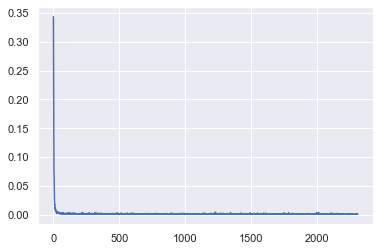

In [20]:
plt.plot(losses);

In [15]:
# plt.plot(losses[:6]);

In [16]:
checkpoint = {"state_dict": model.state_dict(),
              "optimizer": optimizer.state_dict(),
              'loss': loss}
torch.save(checkpoint, f"{models_path}\DefaultModel_{win_size}.pt")
